# Monocle analysis of single-cell sequencing of influenza-infected cells
Study by Alistair Russell, [Cole Trapnell](http://cole-trapnell-lab.github.io/), and [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).

This notebook starts with the annotated cell-gene matrix, and analyzes the expression of influenza-infected cells in various ways. 
It primarily does this using [Monocle](http://cole-trapnell-lab.github.io/monocle-release/)​.

## Setup 
Load or install necessary packages.
As suggested by Cole, we install Monocle from Github rather than using the version in BioConductor.

In [1]:
# commented out the lines below since we are using github version
#if (suppressMessages((!require("monocle", quietly=TRUE)))) {
#  source("http://bioconductor.org/biocLite.R", suppressUpdates=TRUE)
#  biocLite()
#  biocLite("monocle", suppressWarnings=TRUE)
#}

if (!require("pacman", quietly=TRUE)) 
  install.packages("pacman")
pacman::p_load("ggplot2", "ggthemes", "ggExtra", "gridExtra", "cowplot", "scales", "reshape2", 
  "dplyr", "magrittr", "rmarkdown", "IRdisplay", "psych", "qlcMatrix", "devtools")

install_github("cole-trapnell-lab/monocle-release")
library("monocle")    

sessionInfo()

# plots will be saved here
plotsdir <- './results/plots/'
if (!dir.exists(plotsdir)) 
  dir.create(plotsdir)    
    
saveShowPlot <- function(p, width, height) {
  # save plot with filename of variable name with dots replaced by _, then show
  plotfile <- file.path(plotsdir, sprintf("%s.png", 
    gsub("\\.", "_", deparse(substitute(p)))))
  ggsave(plotfile, plot=p, width=width, height=height, units="in")
  display_png(file=plotfile, width=width * 100)
}
    
fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

Skipping install of 'monocle' from a github remote, the SHA1 (44fe75eb) has not changed since last install.
  Use `force = TRUE` to force installation
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMean

R version 3.4.0 (2017-04-21)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Sierra 10.12.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] monocle_2.5.3       DDRTree_0.1.5       irlba_2.2.1        
 [4] VGAM_1.0-3          Biobase_2.36.2      BiocGenerics_0.22.0
 [7] devtools_1.13.2     qlcMatrix_0.9.5     slam_0.1-40        
[10] Matrix_1.2-10       psych_1.7.5         IRdisplay_0.4.4    
[13] rmarkdown_1.5       magrittr_1.5        dplyr_0.7.1        
[16] reshape2_1.4.2      scales_0.4.1        cowplot_0.7.0      
[19] gridExtra_2.2.1     ggExtra_0.6         ggthemes_3.4.0     
[22] gg

## Create cell-gene dataset, examine basic statistics, filter cells 
Read in cell-gene data for all samples.
This is the merged cell-gene data set constructed with `cellranger` using the iPython notebook.
The cells are annotated by the number of wildtype and synonymous-barcoded influenza UMIs called for each cell.

After reading the cells, we just get the samples that interest us (right now this is all samples).

We then estimate the size factors and dispersions.

In [2]:
matrixfile <- "results/cellgenecounts/merged_humanplusflu_matrix.mtx"
genesfile <- "results/cellgenecounts/merged_humanplusflu_genes.tsv"
cellsfile <- "results/cellgenecounts/merged_humanplusflu_cells.tsv"

all.cells <- newCellDataSet(readMM(matrixfile),
  phenoData=new("AnnotatedDataFrame", data=read.delim(cellsfile)),
  featureData=new("AnnotatedDataFrame", data=read.delim(genesfile)),
  expressionFamily=negbinomial.size())

samples <- c("Uninfected", "6hr-1", "8hr-2", "8hr-2repeat", "10hr-2")
all.cells <- all.cells[, row.names(subset(pData(all.cells), Sample %in% samples))]

all.cells <- estimateSizeFactors(all.cells)
all.cells <- estimateDispersions(all.cells)

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Removing 21 outliers
Warning message:
“glm.fit: algorithm did not converge”

Plot the number of cells in each sample.

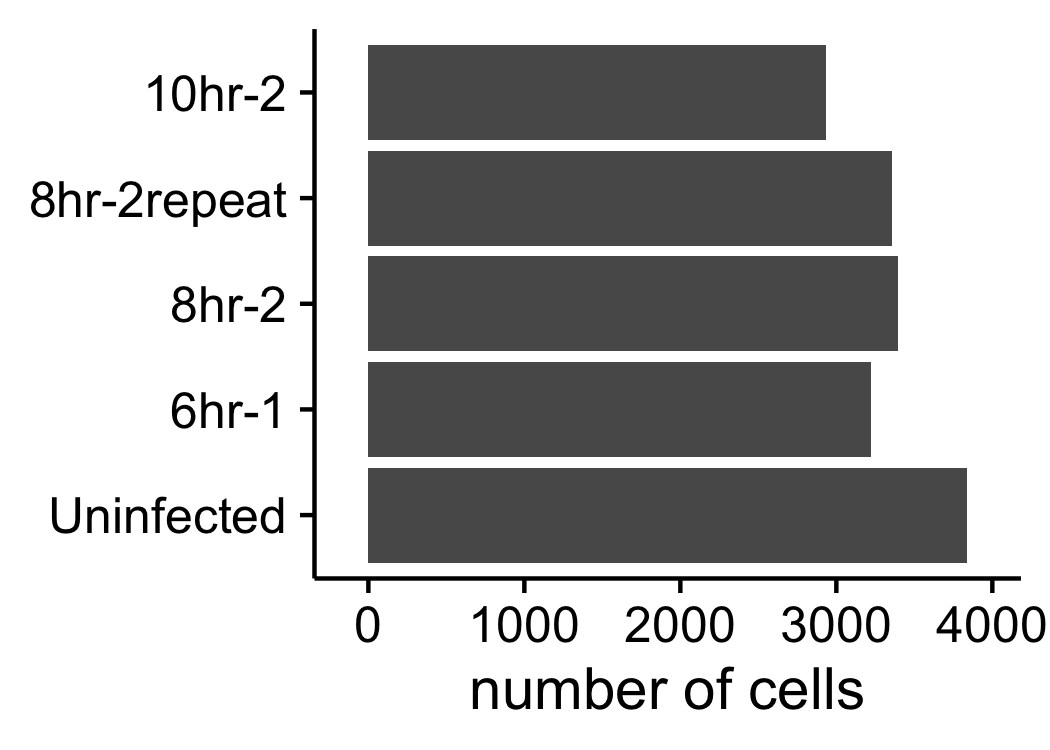

In [3]:
p.ncells.per.sample <- ggplot(
    pData(all.cells) %>% transform(Sample=factor(Sample, samples)) %>% arrange(Sample), 
    aes(Sample)) + 
  scale_y_continuous(name="number of cells", expand=c(0.09, 0)) + geom_bar() + 
  scale_x_discrete(name=NULL) + coord_flip()

saveShowPlot(p.ncells.per.sample, width=3.5, height=2.5)

Compute the number of total mRNAs, cellular mRNAs, influenza mRNAs, and fraction of influenza mRNAs per cell.
Then plot a cumulative distribution plot of the fraction of mRNAs that are from influenza for each sample.

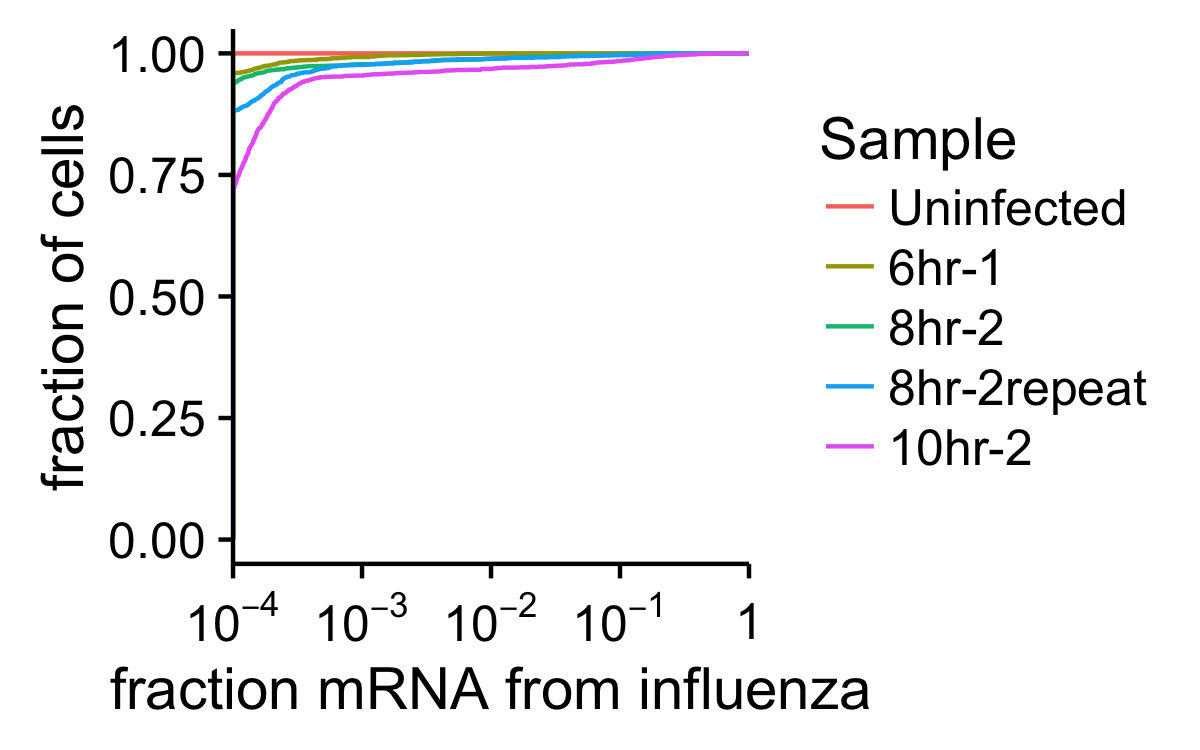

In [4]:
pData(all.cells)$total.mRNAs <- Matrix::colSums(exprs(all.cells))

flugenes <- c("fluPB2", "fluPB1", "fluPA", "fluHA", "fluNP", "fluNA", "fluM", "fluNS")
flugenes.id <- row.names(subset(fData(all.cells), gene_short_name %in% flugenes))
pData(all.cells)$flu.mRNAs <- Matrix::colSums(exprs(all.cells[flugenes.id,]))

cellgenes.id <- row.names(subset(fData(all.cells), !(gene_short_name %in% flugenes)))
pData(all.cells)$cellular.mRNAs <- Matrix::colSums(exprs(all.cells[cellgenes.id,]))

pData(all.cells)$frac.flu.mRNAs <- pData(all.cells)$flu.mRNAs / 
  pData(all.cells)$total.mRNAs

# some trickery around x minimum to avoid taking log of 0 
minx <- 1e-4 # minimum value on y-axis
pData(all.cells)$log.frac.flu <- ifelse(pData(all.cells)$frac.flu.mRNAs < minx, 
  log10(minx), log10(pData(all.cells)$frac.flu.mRNAs))

p.mRNA.per.cell.cumul <- ggplot(
    transform(pData(all.cells), Sample=factor(Sample, samples)), # order by sample 
    aes(log.frac.flu, color=Sample)) +
  stat_ecdf() +
  scale_x_continuous(labels=function(x){fancy_scientific(10**x)},
    limits=c(log10(minx), 0), expand=c(0, 0), name="fraction mRNA from influenza") +
  scale_y_continuous(limits=c(0, 1), name="fraction of cells") + 
  theme(axis.text.x=element_text(vjust=0.2))

saveShowPlot(p.mRNA.per.cell.cumul, width=4, height=2.5)

The `Monocle` vignette suggests filtering cells with far more / less mRNAs than most cells.
I have done that leniently, allowing cells to have substantially more or less than the mean number of mRNAs per cells.
The reason that the filtering on mRNA abundance is so lenient is because many of the strongly influenza-infected cells tend to have more mRNAs than typical cells.
This fact is made more clear by the next plot, which shows that cells with >1% of their mRNAs from influenza tend to have more total mRNAs than other cells.
I can think of several possible explanations:

  1. Influenza preferentially infects bigger cells.

  2. Influenza infection leads cells to produce more mRNAs.

  2. Influenza infection preferentially causes "doublets"" due to cell clumping, perhaps mediated by hemagglutinin-based cross-linking of cells.

In any case, it seems safer to filter leniently.
In the plot below, the vertical gray lines show the lower and upper bounds on mRNA number applied to each sample.
There is a sample-specific cutoff since different samples were sequenced to different depth.

Sample,mean,lower.bound,upper.bound
10hr-2,13625.441,5046.460,36788.69
6hr-1,6373.145,2360.424,17207.49
8hr-2,13691.730,5071.011,36967.67
8hr-2repeat,5480.355,2029.761,14796.96
Uninfected,13258.968,4910.729,35799.21


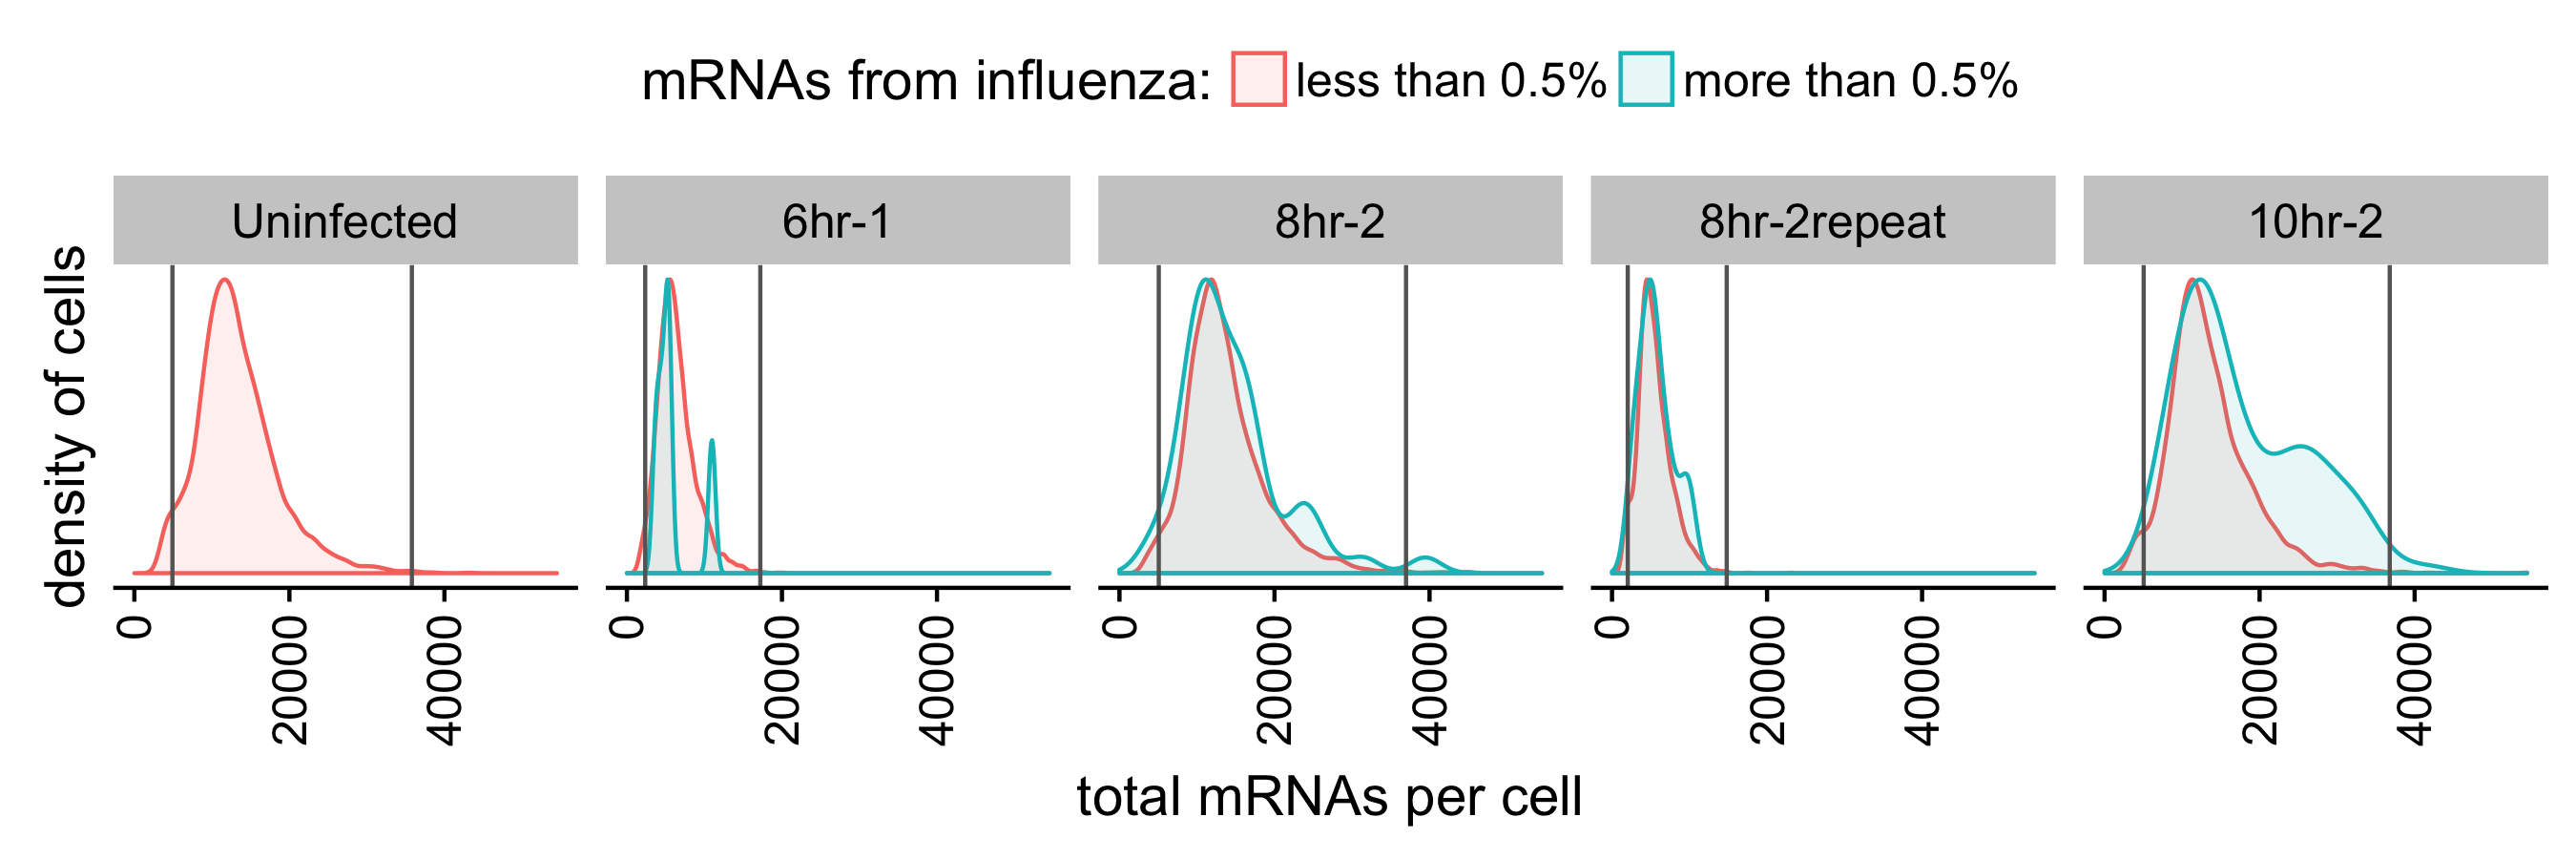

In [5]:
# set upper and lower bounds as range around mean for each sample
pData(all.cells)$sample.mean.mRNAs <- pData(all.cells) %>% group_by(Sample) %>% 
  mutate(mean=mean(total.mRNAs)) %>% ungroup %>% select(mean) %>% unlist
pData(all.cells)$lower.bound <- pData(all.cells)$sample.mean.mRNAs / 2.7
pData(all.cells)$upper.bound <- pData(all.cells)$sample.mean.mRNAs * 2.7

# print table of upper and lower bounds for each sample
pData(all.cells) %>% group_by(Sample) %>% summarize(mean=first(sample.mean.mRNAs), 
  lower.bound=first(lower.bound), upper.bound=first(upper.bound)) 

# classify cells with more and less than 0.5% flu mRNAs
pData(all.cells)$frac.flu.0.005 <- ifelse(pData(all.cells)$frac.flu.mRNAs > 0.005,
  "more than 0.5%", "less than 0.5%")

# plot density of mRNAs per cell with cutoffs shown but not yet applied
p.mRNA.density <- ggplot(
    transform(pData(all.cells), Sample=factor(Sample, samples)), 
    aes(total.mRNAs, color=frac.flu.0.005, fill=frac.flu.0.005)) +
  geom_density(alpha=0.1, aes(y=..scaled..)) +
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1), legend.position="top") +
  scale_y_continuous(label=NULL, name="density of cells", breaks=NULL, limits=c(0, NA)) +
  scale_x_continuous(limits=c(0, NA)) +
  xlab("total mRNAs per cell") +
  labs(color="mRNAs from influenza:", fill="mRNAs from influenza:") +
  geom_vline(aes(xintercept=lower.bound), color="gray40") +
  geom_vline(aes(xintercept=upper.bound), color="gray40") +
  facet_wrap(~Sample, nrow=1, scales="free_y")

saveShowPlot(p.mRNA.density, width=9, height=3)

# now apply cutoffs on mRNA abundance to cells
cells <- all.cells[, row.names(subset(pData(all.cells), 
    total.mRNAs > lower.bound & total.mRNAs < upper.bound))]

Now that we have filtered the cells, plot the number of influenza mRNAs versus the number of cellular RNAs.
The blue curves show the overall density of the number of cellular mRNAs.

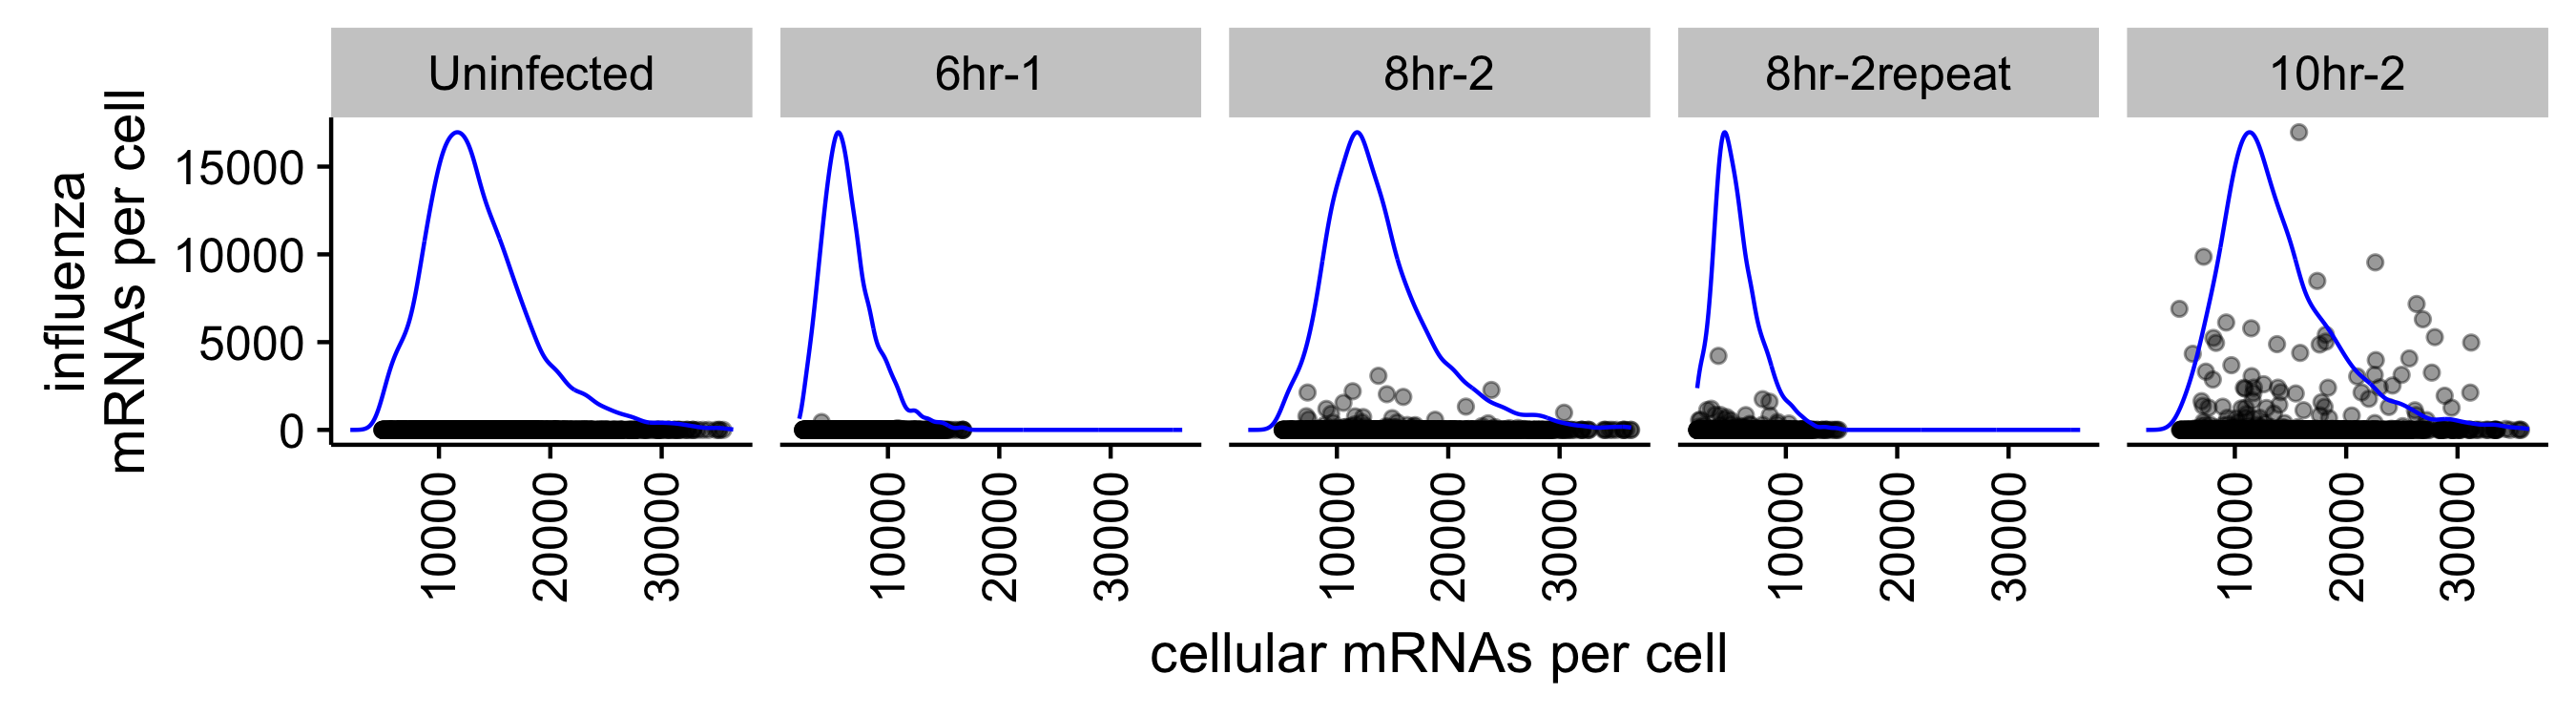

In [6]:
scatterplot <- ggplot(
    transform(pData(cells), Sample=factor(Sample, levels=samples)), # order by sample
    aes(cellular.mRNAs, flu.mRNAs)) +
  geom_point(alpha=0.4)

# use eval substitute to get value of maxy as here: https://stackoverflow.com/a/10659563
densityplot <- eval(substitute(
  {stat_density(aes(x=cellular.mRNAs, y=maxy*(..scaled..)), geom="line", color='blue')},
  list(maxy=layer_scales(scatterplot)$y$range$range[2])))

p.flu.vs.cell <- scatterplot + densityplot + 
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
  facet_wrap(~Sample, nrow=1) + xlab("cellular mRNAs per cell") + 
  ylab("influenza\nmRNAs per cell")

saveShowPlot(p.flu.vs.cell, width=9, height=2.5)

Make a summary plot merging all these panels. 
This is designed to be a publication-quality figure.

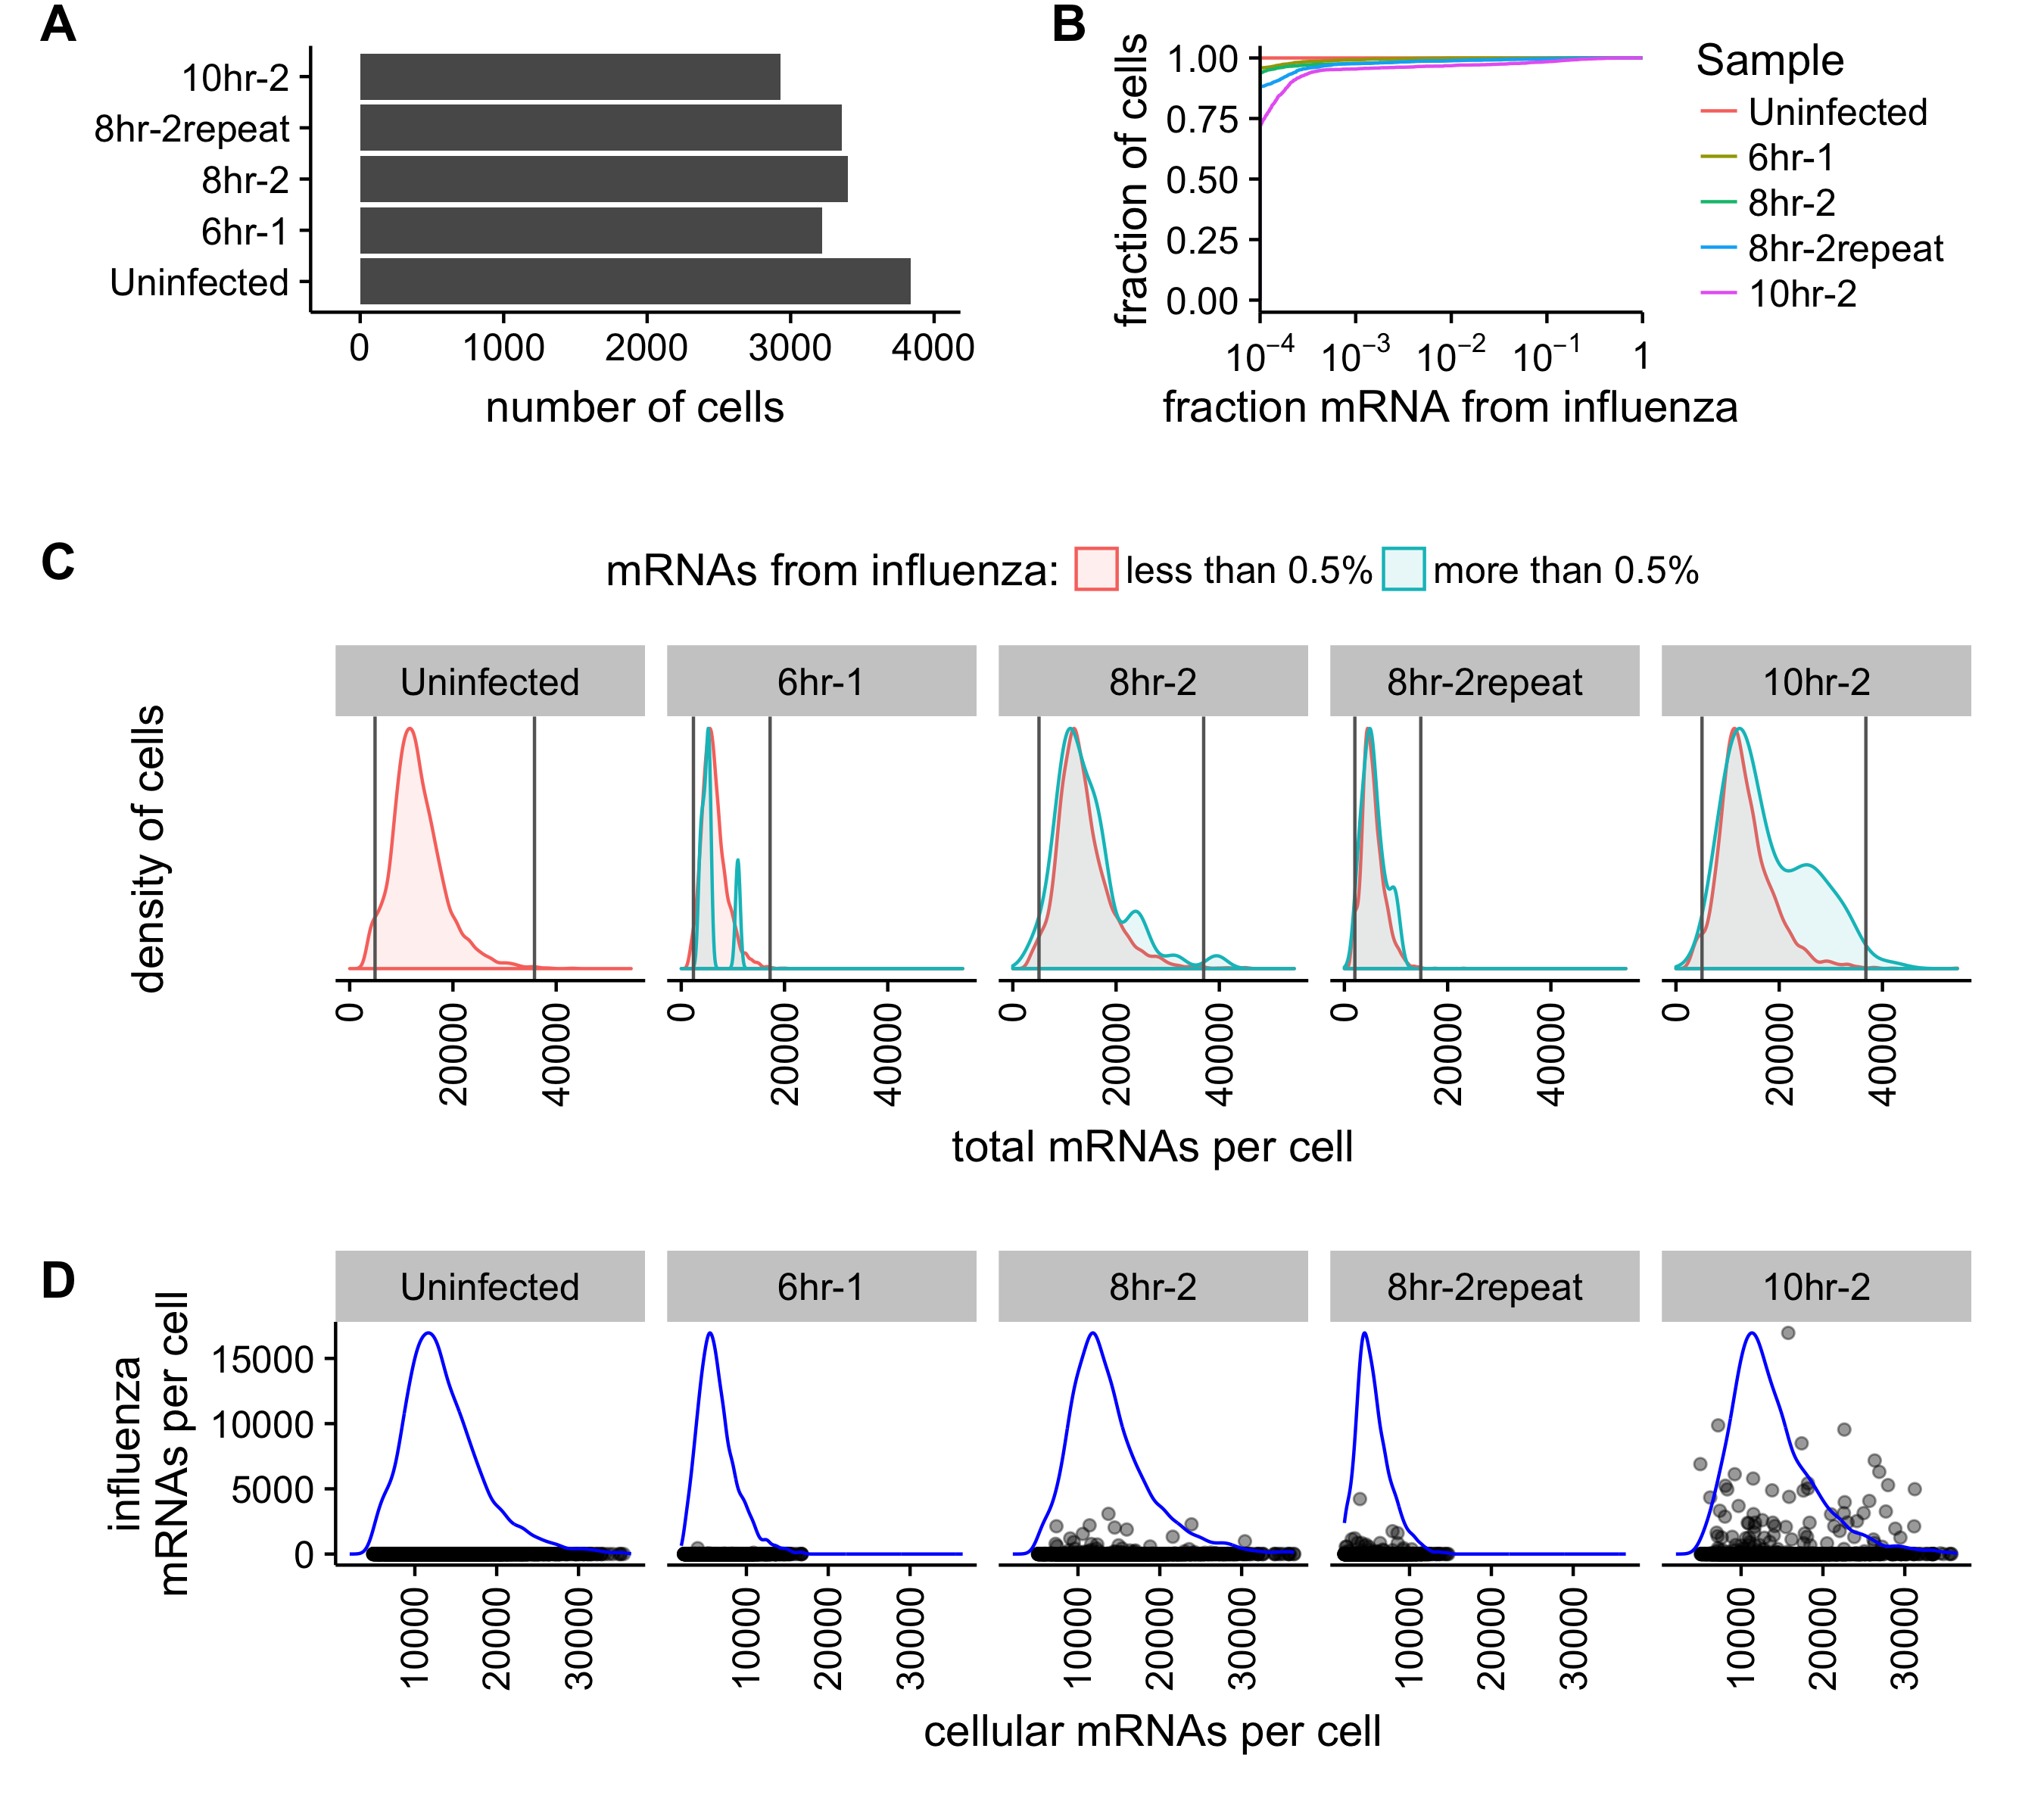

In [7]:
p.cell.mRNA.summary <- plot_grid(
  plot_grid(p.ncells.per.sample, p.mRNA.per.cell.cumul, ncol=2, align='h', 
    labels=c("A", "B"), label_size=16, vjust=-0.2, scale=0.9),
  plot_grid(p.mRNA.density, p.flu.vs.cell, ncol=1, align='v', labels=c("C", "D"),
    rel_heights=c(1.25, 1), label_size=16, scale=0.95),
  ncol=1, rel_heights=c(1, 2.7)
  )

saveShowPlot(p.cell.mRNA.summary, width=9, height=8)

## Look at levels of influenza genes, use synonymous barcodes to detect true infection / co-infection versus mRNA leakage, filter cells
Roughly half of the infecting influenza viruses had a synonymous barcode at the 3' end of each mRNA.
If cells infected by a single virus (which we expect to be the most common case for infected cells since infection itself is rare), then they should generally have either all wildtype or all synonymously barcoded viruses.
Looking for deviations from this expectation can identify both true infection / co-infection and cells that just got some influenza mRNA by leakage, since such leakage is expected to introduce a mix of both wildtype and synonymously barcoded.
Establishing when cells start to have influenza mRNA due to true infection versus simple leakage is important for figuring identifying truly infected cells.

Note that we have counted influenza mRNAs from the standard 10X sequencing of the full transcriptome.
However, we have also called the synonymous versus wildtype barcodes using some extra semi-specific PCR which is not included in the cell-gene count data due to the fact that it is biased towards some genes, but does provide extra depth on the barcode counts.
We limit the analysis below to cells that meet the following criteria:

  1. They have at least two influenza reads in the cell-gene matrix.

  2. They have at least two called barcodes (synonymous or wildtype) in the cell-gene matrix plus extra semi-specific PCR.

These criteria are a way to limit the analysis just to cells where there is actual information about the synonymous barcodes.
First, we filter down to these cells and plot some information about them.
Note that these plots show the number of influenza mRNAs on a log scale, and then color the bars by the fraction of reads from each barcode.
So the heights of each color in the bars are proportional to the fraction of the reads with that barcode, they are **not** the log of the number of reads with each barcode.

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over all variables, use `mutate_all()`
Warning message in `[<-.factor`(`*tmp*`, list, value = 0):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, list, value = 0):
“invalid factor level, NA generated”Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


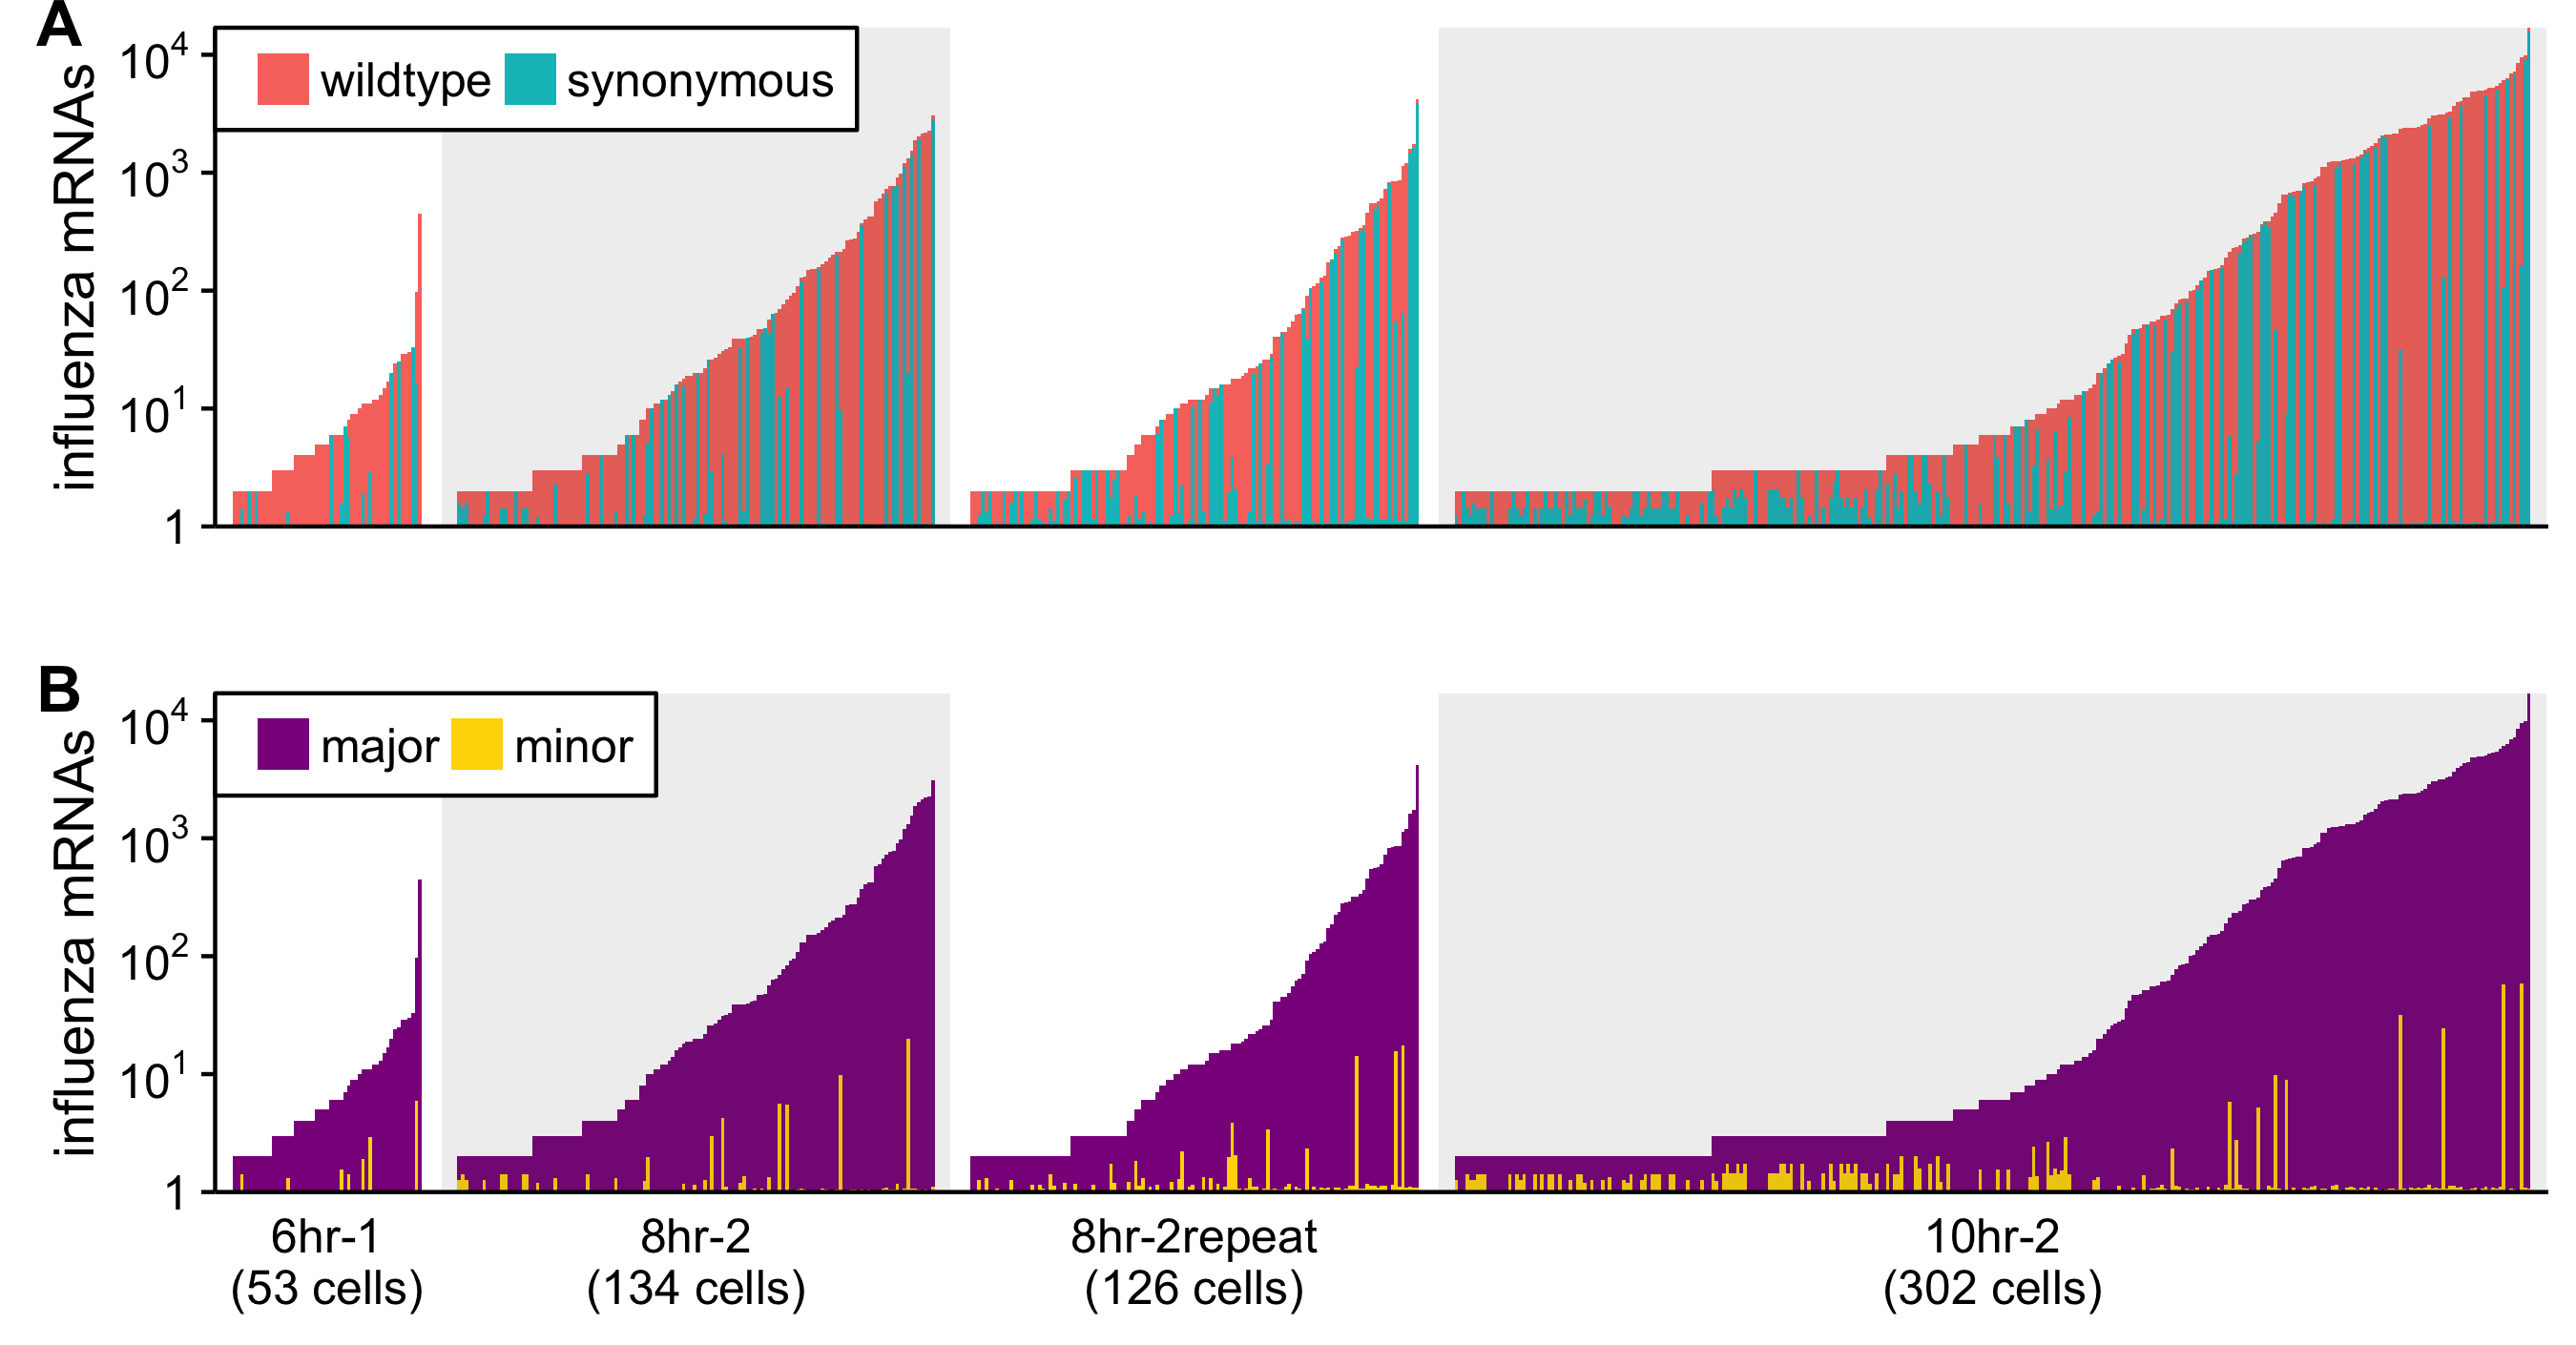

In [8]:
# filter on sufficiently barcoded cells and samples with such cells
bc.cells <- filter(pData(cells), flu.mRNAs >= 2, flu.wt + flu.syn >= 2)
samples.to.plot <- bc.cells[["Sample"]] %>% unlist %>% unique

# make variables with product of log flu mRNAs times fraction with each barcode
bc.cells <- bc.cells %>% mutate(frac.wt=(flu.wt / (flu.wt + flu.syn))) %>%
  mutate(wildtype=log10(flu.mRNAs) * frac.wt, 
    synonymous=log10(flu.mRNAs) * (1 - frac.wt)) %>%
  mutate(major=pmax(wildtype, synonymous), minor=pmin(wildtype, synonymous))

# make some dummy rows with 0 or many influenza to "pad" between samples on the plot
npad <- 5 # pad this many cells on each side of each sample
bc.cells.padded <- lapply(samples.to.plot, function(s) {data.frame(Sample=rep(s , 2 * npad), 
    flu.mRNAs=c(rep(0, npad), rep(1e8, npad)))}) %>%
  bind_rows(., bc.cells) %>% mutate_each(funs(replace(., is.na(.), 0)))

# order bc_cells by sample and flu abundance
bc.cells.padded$Sample <- factor(bc.cells.padded$Sample, samples.to.plot)
bc.cells.padded <- arrange(bc.cells.padded, Sample, flu.mRNAs)
bc.cells.padded$indx <- as.numeric(row.names(bc.cells.padded))

# get min and max indx for each sample
indxrange <- bc.cells.padded %>% filter(major > 0) %>% group_by(Sample) %>% 
  summarize(imax=max(indx), imin=min(indx)) %>%
  mutate(center=(imin + imax) / 2, label=sprintf("%s\n(%d cells)", Sample, imax - imin + 1))

purityplot <- function (barcodes) {
  # plot purity of barcoded cells using barcode type specified by *barcodes*
  ggplot(melt(bc.cells.padded, id.vars=c("indx", "Sample"), measure.vars=barcodes, 
      variable.name="barcode"),
    aes(x=indx, y=value)) +
  geom_bar(aes(fill=barcode), stat="identity", position="stack", width=1) +
  scale_y_continuous(name="influenza mRNAs", expand=c(0, 0), 
    labels=function(y){fancy_scientific(10**y)}) +
  scale_x_continuous(expand=c(0, 0), name=NULL, breaks=indxrange$center, labels=indxrange$label) +
  theme(axis.ticks.x=element_blank(), legend.position=c(0, 1),
    legend.justification=c(0, 1), legend.direction="horizontal",
    legend.background=element_rect(fill="white", size=0.5, linetype="solid", color="black")) +
  scale_fill_discrete("") +
  geom_rect(data=data.frame(xmin=indxrange$imin[seq(2, nrow(indxrange), 2)] - npad,
    xmax=indxrange$imax[seq(2, nrow(indxrange), 2)] + npad, ymin=-Inf, ymax=Inf),
    aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.1, inherit.aes=FALSE)
}

p.wt.syn <- purityplot(c("wildtype", "synonymous"))
p.major.minor <- purityplot(c("major", "minor"))
p.barcode.purity <- plot_grid(p.wt.syn + theme(axis.text.x=element_blank()),
  p.major.minor + scale_fill_manual(values=c("darkmagenta", "gold"), name=NULL),
  nrow=2, align='h', labels=c("A", "B"), label_size=16, vjust=1)

saveShowPlot(p.barcode.purity, width=9, height=4.7)

Now let's try to find a good cutoff for the fraction of influenza reads per cell that seems to indicate true infection rather than co-infection.
To do this, we continue to subset on the cells with at least 2 influenza reads and 2 called wildtype / synonymous barcodes.
For each fraction of influenza reads per cell, we then calculate the mean barcode purity in cells with > this fraction of influenza reads. 
The goal is to find a lowest cutoff at which higher fraction of influenza reads doesn't lead to substantially higher purity.
This indicates that we have reached the point where most of the mixing that we are detecting is due to true co-infection, rather than cells that simply have "leaked" influenza reads.

We find the cutoff by fitting a smoothed loess line to the mean purity as a function of the cutoff, and then drawing the line a bit above where the derivative of that smoothed loess line becomes zero.

Looking at the plots above, it's clear that the cutoff should be higher for the samples with more influenza infection, since those samples clearly have more leakage. 
However, to be conservative we compute a cutoff using the sample with the **most** influenza mRNAs in infected cells (this sample will have the most leakage and so the highest cutoff), and then apply this cutoff to all samples.
This approach is conservative in the sense that we are making the cutoff a bit higher than needed for the lower-influenza samples.
However, this seems safer than estimating a different cutoff for each sample, as the lower number of cells with multiple barcoded mRNAs for the lower-influenza samples makes it harder to estimate a reliable cutoff for these samples.

Computing purity cutoff for sample with most influenza, 10hr-2

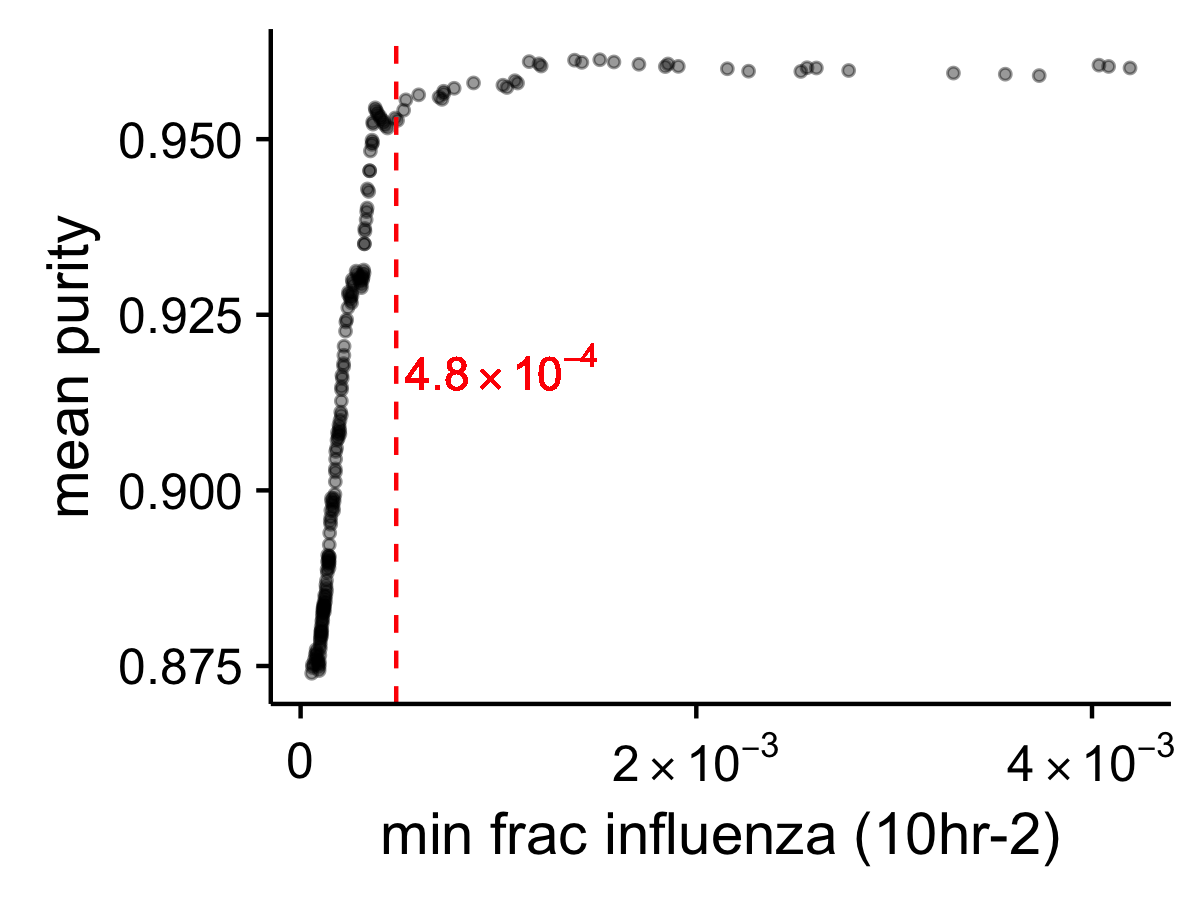

In [9]:
# get the sample with the most flu positive cells, compute purity cutoff on it
sample.most.flu <- bc.cells %>% group_by(Sample) %>% summarise(cells=n()) %>% 
  arrange(cells) %>% tail(n=1) %>% .$Sample %>% sprintf("%s", .) 
cat("Computing purity cutoff for sample with most influenza,", sample.most.flu)
bc.cells <- filter(bc.cells, Sample == sample.most.flu)

# compute purity to only out this far, as curve has flattened by about 50th percentile
frac.flu <- bc.cells$frac.flu.mRNAs %>% sort %>% head(-as.integer(0.35 * nrow(bc.cells)))

# mean of major barcode frequency with cells <= indication fraction flu
bc.cells <- mutate(bc.cells, purity=pmax(wildtype, synonymous) / (wildtype + synonymous))
purity <- data.frame(frac.flu)
purity$mean <- lapply(frac.flu, function (f) {bc.cells %>% filter(frac.flu.mRNAs > f) %>% 
  select(purity) %>% as.vector %>% unlist %>% mean}) %>% unlist

# threshold where derivative of purity with respect to fraction flu stops being positive
deriv.purity <- loess(mean~frac.flu, data=purity) %$% fitted %>% diff
i.threshold <- which(deriv.purity <= 0) %>% min  
threshold.frac <- frac.flu[i.threshold] * 1.5

# plot the data and threshold line
p.purity.threshold <- ggplot(purity, 
    aes(x=frac.flu, y=mean)) + geom_point(size=1, alpha=0.4) + 
  scale_y_continuous(name="mean purity", 
    limits=c(min(purity$mean), max(purity$mean))) +
  scale_x_continuous(name=sprintf("min frac influenza (%s)", sample.most.flu), 
    labels=fancy_scientific, breaks=pretty_breaks(n=2)) +
  theme(axis.text.x=element_text(vjust=0.2)) +
  geom_vline(xintercept=threshold.frac, color="red", linetype="dashed") + 
  geom_text(aes(threshold.frac, mean(c(min(purity$mean), max(purity$mean))), 
      label=fancy_scientific(threshold.frac, parse.str=FALSE, digits=2), hjust=-0.05), 
    parse=TRUE, color="red")

saveShowPlot(p.purity.threshold, width=4, height=3)

Now we can annotate cells as *infected* based on whether they have more than this threshold fraction of reads from influenza.

We also annotate cells as *coinfected* if they have **both**:

  1. More than the threshold fraction of reads from their minor barcode (where the threshold fraction is defined as the above amount giving the fraction of influenza reads needed to consider that we have a "true" infection).
  2. More than 5% of their barcoded influenza reads from their minor barcode. 
  
Note that we do not expect to identify all of the co-infected cells. 
Even if the wildtype and synonymously barcoded viruses are mixed at exactly equal ratios, we expect half of the co-infected cells to receive two of the same virus barcode, and so be undetectably co-infected.

We then plot the distribution of influenza reads per cell among the clearly infected or co-infected cells for each sample.

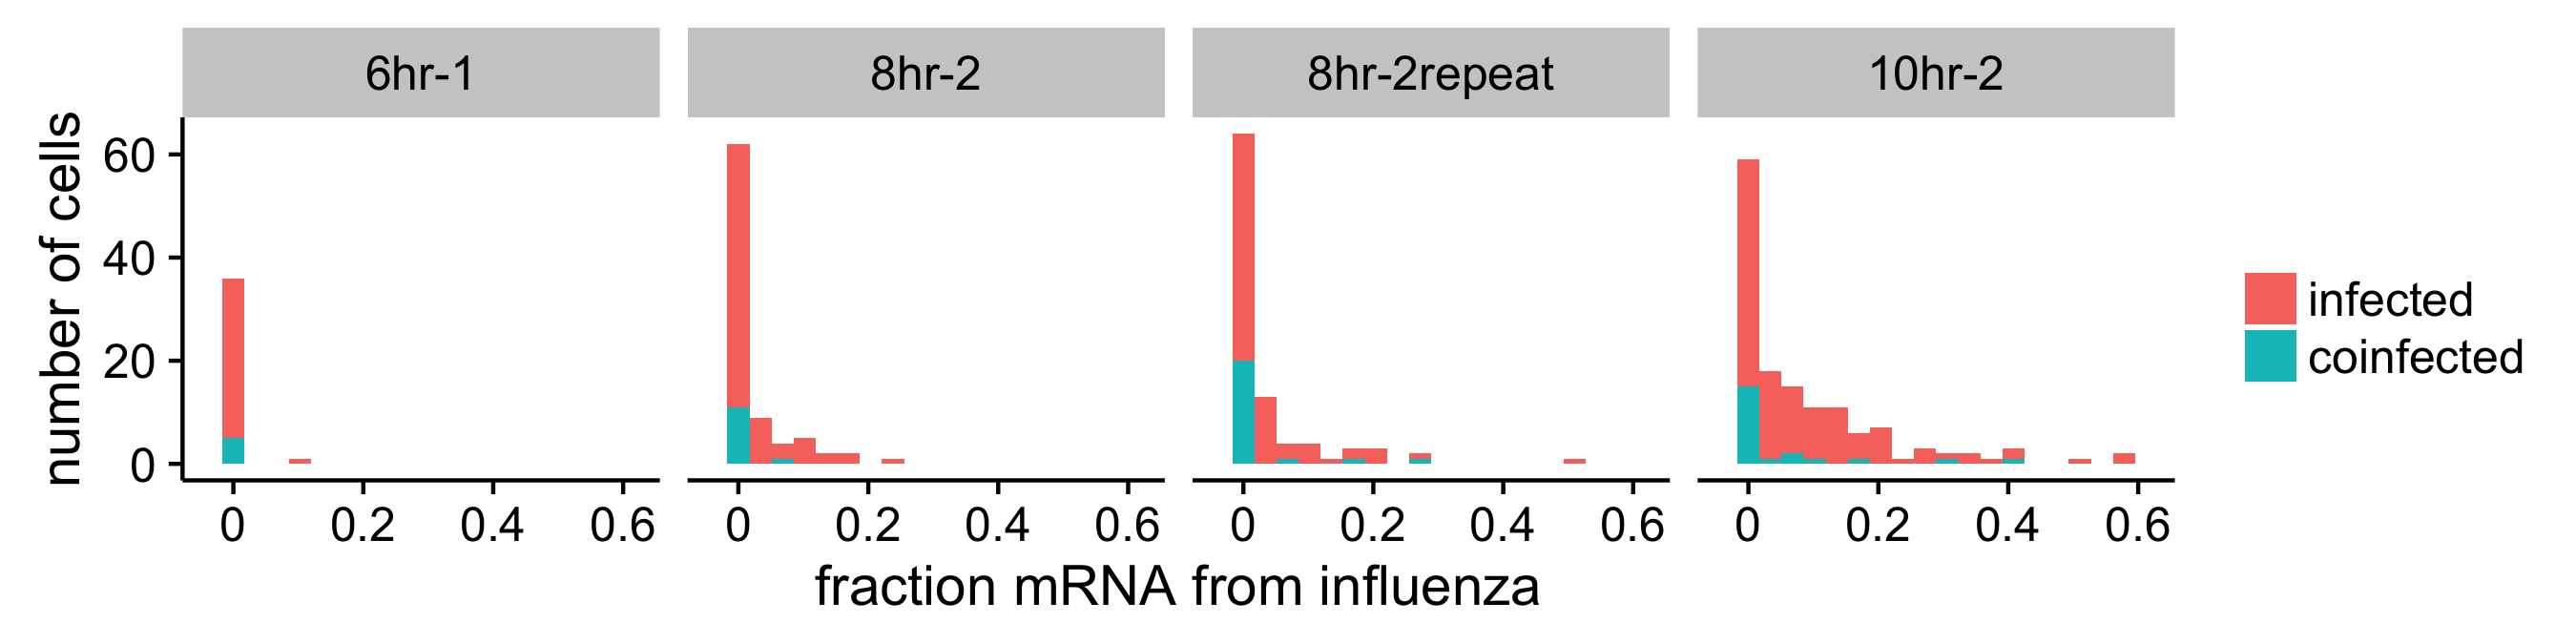

In [10]:
# annotate cells as infected or coinfected
coinfect.threshold <- 0.05 # coinfected requires >= this fraction minor barcode 
pData(cells)$infected <- pData(cells)$frac.flu.mRNAs > threshold.frac
pData(cells)$minor <- pmin(pData(cells)$flu.wt, pData(cells)$flu.syn) /
  (pData(cells)$flu.wt + pData(cells)$flu.syn)
pData(cells)$minor <- ifelse(is.na(pData(cells)$minor), 0, pData(cells)$minor)
pData(cells)$n.minor <- pData(cells)$minor * pData(cells)$flu.mRNAs
pData(cells)$coinfected <- pData(cells)$infected & 
  (pData(cells)$minor > coinfect.threshold) & (pData(cells)$n.minor > threshold.frac)

# plot number of infected / co-infected cells
xlabeler <- function(x) {ifelse(x%%1, sprintf("%.1f", x), sprintf("%d", x))}
p.frac.flu <- ggplot(
    pData(cells) %>% filter(infected) %>%  
      mutate(infection=ifelse(coinfected, "coinfected", "infected")) %>%
      transform(infection=factor(infection, c("infected", "coinfected")),
        Sample=factor(Sample, samples)) %>% 
      arrange(Sample, infection), 
    aes(frac.flu.mRNAs, fill=infection)) + 
  geom_histogram(bins=18) + facet_wrap(~Sample, nrow=1) + scale_fill_discrete("") +
  scale_y_continuous(name="number of cells") + 
  scale_x_continuous(name="fraction mRNA from influenza", labels=xlabeler, expand=c(0.1, 0))

saveShowPlot(p.frac.flu, width=9, height=2.25)

We have a very large number of uninfected cells and a very small number of infected ones.
If we work with this entire dataset, it will therefore be heavily dominated by the uninfected cells.
We will therefore subsample the uninfected cells to get a more balanced composition of the different types of cells. 
Specifically, we subsample as follows:
  1. We keep **all** of the *infected* cells based on the threshold described above (as well as all the *coinfected* ones, which are a subset of the *infected* ones).
  2. We then keep a fraction of the *uninfected* cells. We choose the *uninfected* cells to retain for each *Sample* as follows:
    i. We set a number of *uninfected* cells to retain that is equal to the larger of the number of infected cells for that *Sample* or 50.
    ii. We order the *uninfected* cells by the amount of influenza mRNA (recall that even the uninfected cells may have a bit due to leakage), and preferentially choose our cells with the lowest amount of influenza mRNA to ensure that we're getting truly uninfected cells. Usually this means that we choose cells with no influenza mRNA, although for samples with higher influenza burden there could still be a few if there aren't enough cells with no influenza mRNA.

Below we make these selections, and then tabulate the number of cells in each category.

In [13]:
# get uninfected cells to keep; first assign original row names 
uninfected.cells <- pData(cells) %>% (tibble::rownames_to_column) %>% filter(!infected)
# set seed to make reproducible, re-shuffle rows, sort so lowest flu first
set.seed(1) 
uninfected.cells <- uninfected.cells[sample(nrow(uninfected.cells)),] %>% 
  arrange(flu.mRNAs)
rows.to.keep <- c()
# now select uninfected cells for each sample
for (s in samples) {
  n <- max(50, nrow(pData(cells) %>% filter(Sample == s, infected)))
  s.rows.to.keep <- uninfected.cells %>% filter(Sample == s) %>% head(n=n) %$% rowname
  rows.to.keep <- c(rows.to.keep, s.rows.to.keep)
}

# annotate as uninfected the uninfected cells that we are keeping
pData(cells)$uninfected <- FALSE
pData(cells)[rows.to.keep, which(colnames(pData(cells)) == "uninfected")] <- TRUE

# summarize number of cells in each category by sample
infected.summary <- pData(cells) %>% group_by(Sample) %>% 
  summarise(cells=n(), infected=sum(infected), coinfected=sum(coinfected), 
    uninfected.kept=sum(uninfected)) %>%
  mutate(coinfected=ifelse(is.na(coinfected), 0, coinfected)) %>% 
  transform(Sample=factor(Sample, samples)) %>% arrange(Sample) 
names(infected.summary) <- gsub('\\.', ' ', names(infected.summary))
infected.summary

# keep all infected cells
rows.to.keep <- c(rows.to.keep, pData(cells) %>% subset(infected) %>% row.names)

# select the cells we are keeping
cells <- cells[, rows.to.keep]

Sample,cells,infected,coinfected,uninfected kept
Uninfected,3713,0,0,50
6hr-1,3153,37,5,50
8hr-2,3320,85,12,85
8hr-2repeat,3248,95,23,95
10hr-2,2843,142,22,142


Finally, we merge these plots / tables with the ones aboved used to call infection / co-infection into a publication-quality figure.

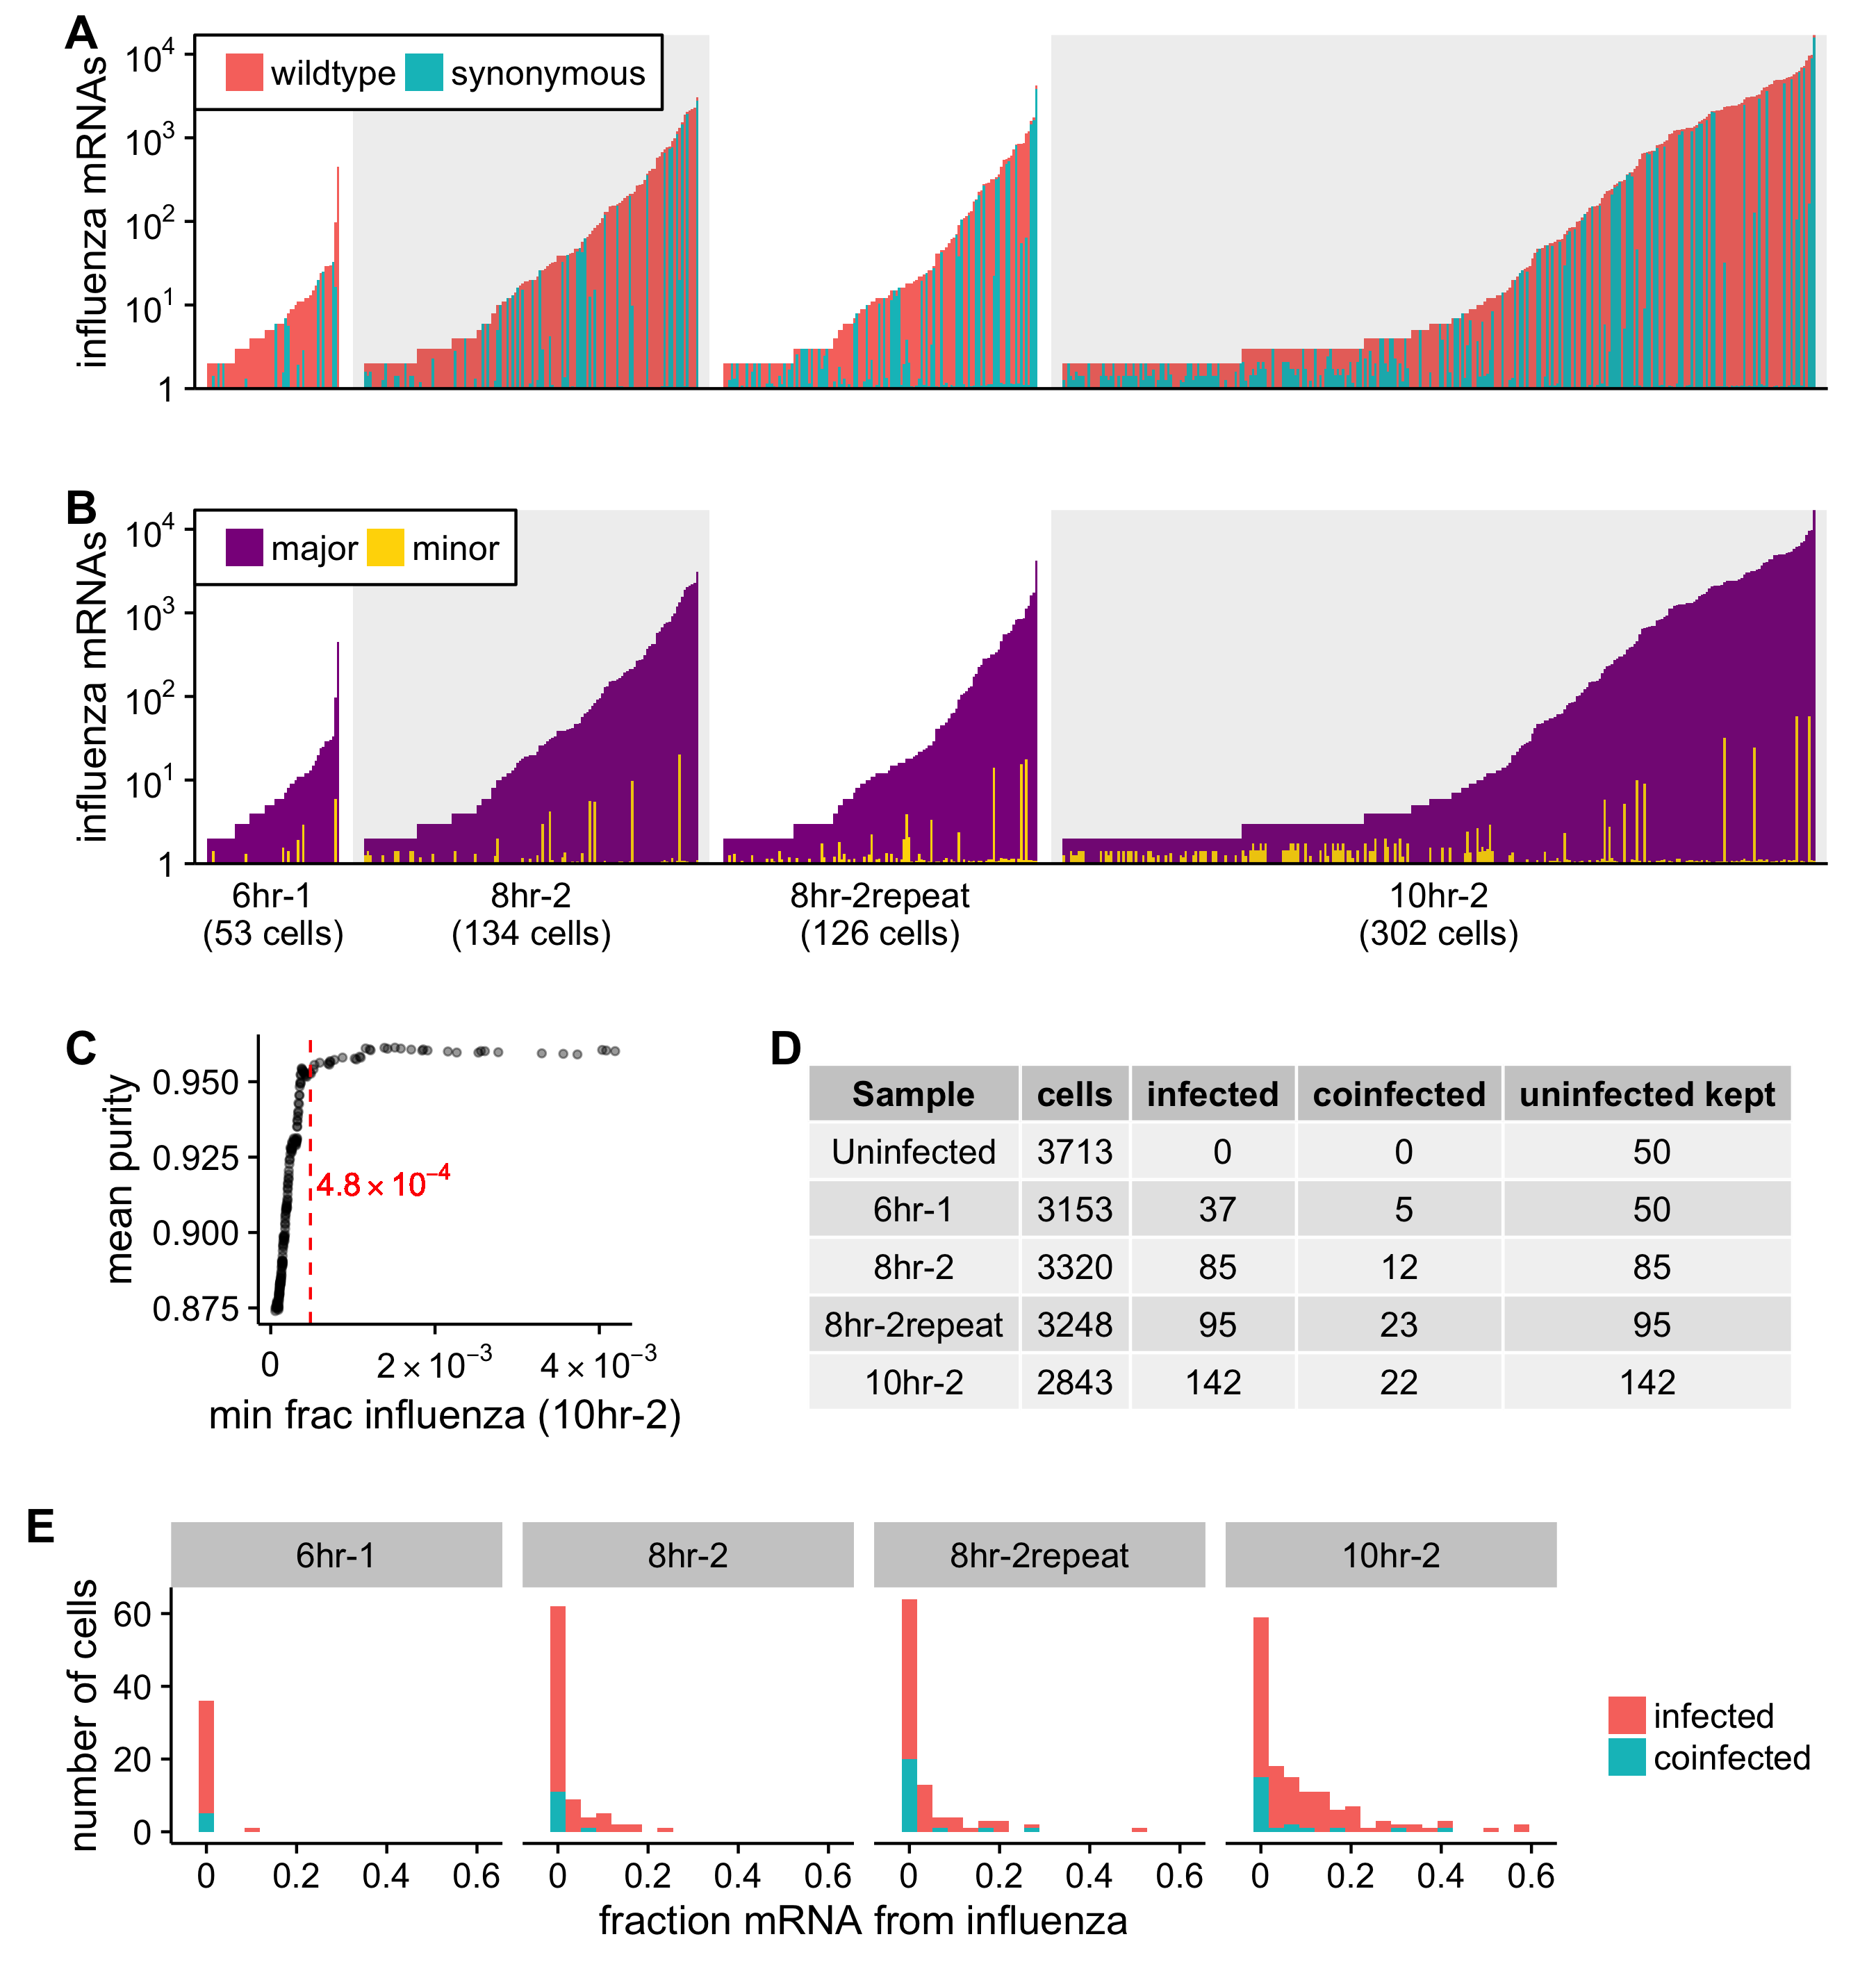

In [14]:
# blank to fill space
blank <- ggplot() + geom_blank(aes(1,1)) + theme_nothing()

# layout in one nice figure
p.frac.flu.summary <- plot_grid(
  p.barcode.purity, 
  plot_grid(p.purity.threshold, blank, infected.summary %>% tableGrob(rows=NULL), scale=0.93, 
    labels=c("C", "", "D"), label_size=16, vjust=1, nrow=1, rel_widths=c(0.8, 0.1, 1.4)), 
  p.frac.flu,
  labels=c("", "", "E"), label_size=16, vjust=1, ncol=1, 
  rel_heights=c(1, 0.51, 0.48), scale=0.97)

saveShowPlot(p.frac.flu.summary, width=9, height=9.5)

## Filter the set of genes to consider further

We will only focus on genes that are expressed at a meaningful level.
First, we filter out genes that are not expressed in any cells.

In [15]:
cells <- detectGenes(cells)
cells <- cells[row.names(subset(fData(cells), num_cells_expressed > 0)), ]

Now for each gene we get the maximum expression in any cell, and annotate whether the gene is viral or cellular.
For cellular genes, we also annotate whether it is a type I interferon based on whether the name starts with IFN.

In [16]:
# get max expression in any cell
fData(cells)$max.expression <- cells %>% exprs %>% (qlcMatrix::rowMax) %>% as.double

# Annotate mRNA source as influenza, IFN, or cellular
# We look for IFN alpha, beta, and lambda but not receptors
ifngenes <- grep("^IFN[ABL][^R]", fData(cells)$gene_short_name, value=TRUE)
cat("Annotating the following genes as IFN:", ifngenes)
fData(cells)$source <- ifelse(fData(cells)$gene_short_name %in% flugenes, 
  "influenza", ifelse(fData(cells)$gene_short_name %in% ifngenes, "IFN", "cellular"))

Annotating the following genes as IFN: IFNB1 IFNL3 IFNL2 IFNL1

We then plot the number of cells that express a gene versus its maximum expression. 

The Monocle vignette suggests only filtering for genes that are expressed in some reasonable fraction of cells.
But as is clear from the plot, below there are some genes that are substantially expressed in only a few (or in some cases even just one) cell, but are clearly biologically significant as they are either type I interferons or influenza genes. 
So instead, we filter the genes based on the **maximum** expression of a gene in any cell.
The gray line shows the filter; we only consider genes to the right of this gray line.

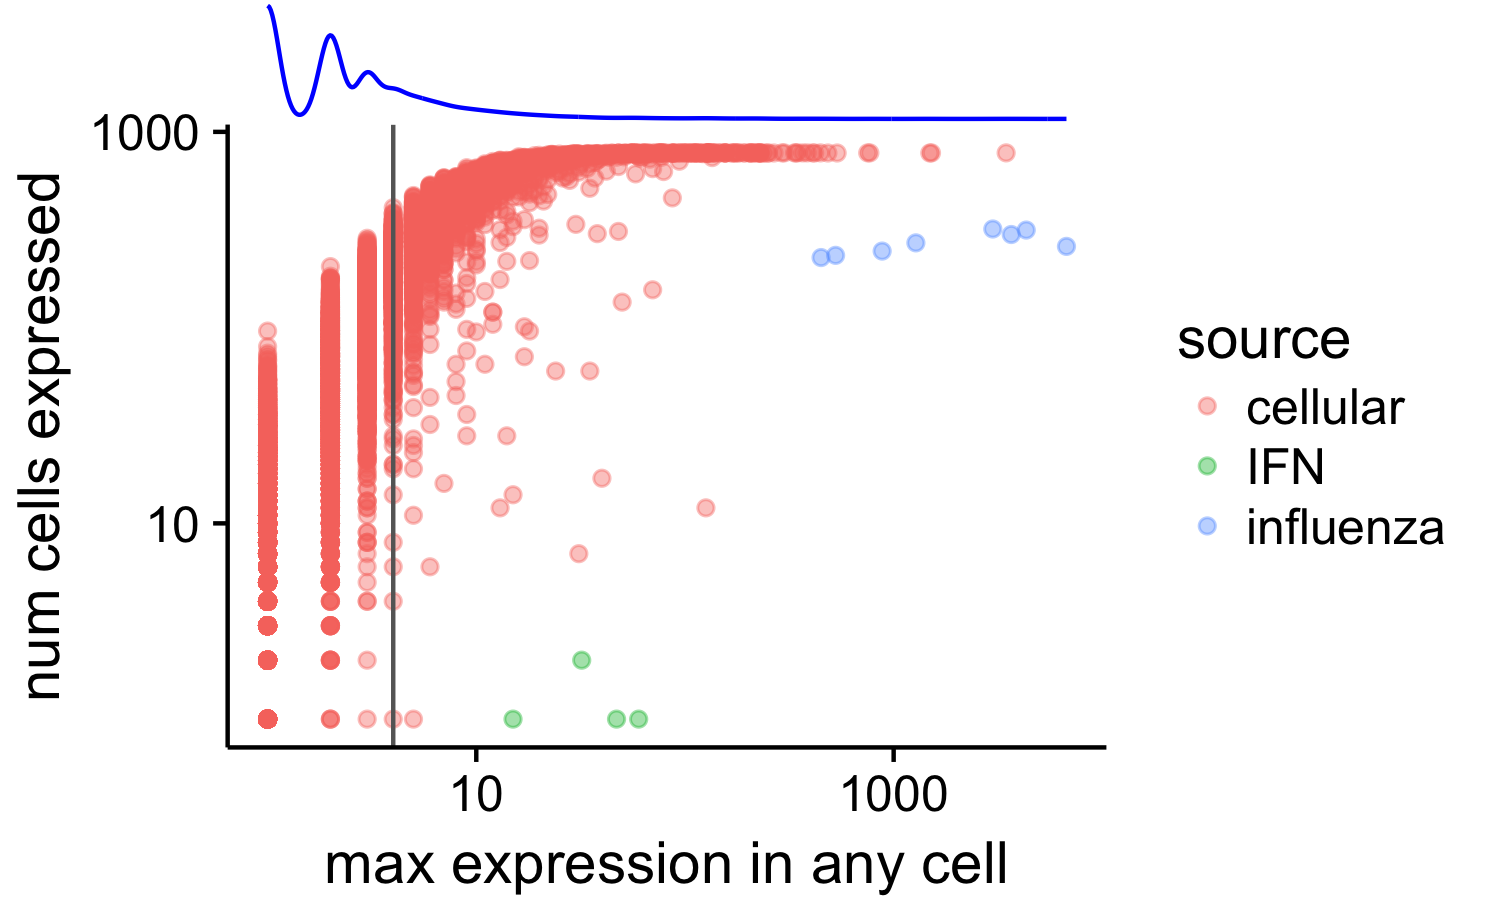

In [17]:
max.expr.cutoff = 4 # only consider genes with more than this much max expression

p.maxexpr.ncells <- ggplot(fData(cells), 
    aes(max.expression, num_cells_expressed, color=source)) + 
  geom_point(alpha=0.4) + scale_x_log10(name="max expression in any cell") + 
  scale_y_log10(name="num cells expressed") +   
  geom_vline(aes(xintercept=max.expr.cutoff), color="gray40")
p.maxexpr.ncells <- ggMarginal(p.maxexpr.ncells, margins="x", color="blue") 

saveShowPlot(p.maxexpr.ncells, width=5, height=3)

cells <- cells[row.names(subset(fData(cells), max.expression > max.expr.cutoff)), ]

The Monocle vignette suggests verifying that the expression values follow a roughly log-normal distribution.
This next plot follows the vignette to verify that.

Warning message:
“Removed 2041534 rows containing non-finite values (stat_density).”

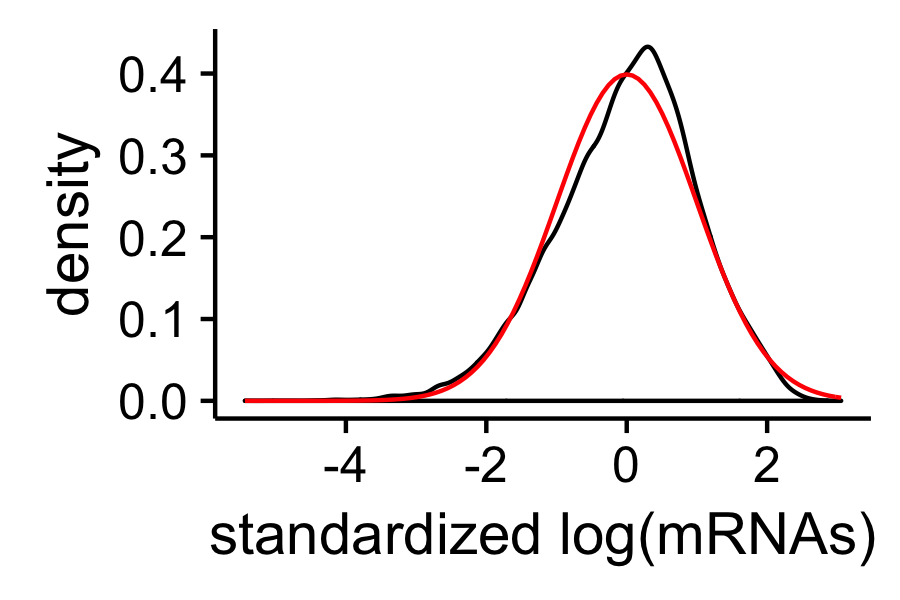

In [18]:
L <- log(exprs(cells))
melted_dens_df <- melt(Matrix::t(scale(Matrix::t(L))))

p.lognormal.expr <- qplot(value, geom="density", data=melted_dens_df) + 
  stat_function(fun = dnorm, size=0.5, color='red') + 
  xlab("standardized log(mRNAs)") + ylab("density")

saveShowPlot(p.lognormal.expr, width=3, height=2)

## Classify cell types
We create a cell-type hierarchy as outlined in the Monocle vignette.

We first create a cell type for virally *infected* cells using the same threshold determined above.
We also classify as *uninfected* any cells with **no** influenza mRNAs.

In [19]:
cth <- newCellTypeHierarchy()

flugenes.id <- row.names(subset(fData(cells), gene_short_name %in% flugenes))
cth <- addCellType(cth, "infected", classify_func=function(x) {
  Matrix::colSums(x[flugenes.id, ]) / Matrix::colSums(x) > threshold.frac})
cth <- addCellType(cth, "uninfected", classify_func=function(x) {
  Matrix::colSums(x[flugenes.id, ]) == 0})

We next create a cell type for IFN+ cells using the definitions of IFN genes above.
We first tabulate the number of these IFN genes per cell in the few cells that express these genes.
As is clear from the table below, most cells have no mRNAs from these IFN genes, and a couple of cells have just a few mRNAs.
We only classify as IFN+ the cell with a substantial expression of these genes.
We make the *IFNpos* classification a subset of the *infected* classification since empirically we see from the table that the *IFNpos* cells is infected.

In [20]:
# number of IFN mRNAs per cell
pData(cells)$IFN.mRNAs <- Matrix::colSums(exprs(cells[row.names(subset(fData(cells), 
  gene_short_name %in% ifngenes)),]))

# print out a summary table
pData(cells) %>% group_by(IFN.mRNAs) %>% summarize(ncells=n(), 
  avg.flu.mRNAs=mean(flu.mRNAs), coinfected=sum(coinfected)) 

# annotate cells as IFN+ if they have lots of IFN mRNAs
ifngenes.id <- row.names(subset(fData(cells), gene_short_name %in% ifngenes))
ifn.threshold <- 50 # classify as IFN+ if > this many IFN mRNAs
cth <- addCellType(cth, "IFNpos", classify_func=function(x) {
  Matrix::colSums(x[ifngenes.id, ]) > ifn.threshold}, parent_cell_type="infected")

IFN.mRNAs,ncells,avg.flu.mRNAs,coinfected
0,779,355.4185,62
1,1,0.0000,0
154,1,6302.0000,0


Now classify the cells according to the cell type hierarchy.
In the classification table below, the *Unknown* cells are those that express at least one influenza mRNA but too little influenza mRNA to be above our threshold for clear infection.

In [21]:
cells <- classifyCells(cells, cth)
table(pData(cells)$CellType)

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”


    IFNpos   infected uninfected 
         1        358        422 

## Unsupervised clustering of the cells
As in the Monocle vignette, we now perform unsupervised clustering.
This does not appear to yield anything useful, but we do it anyway as tSNE plots seem to be a standard thing that people show.

First, we filter on the genes to use in the clustering. 
We use a slightly more lenient cutoff than in the Monocle vignette for *mean_expression=0.1*.
We then plot the dispersion versus the mean expression, and the variance explained by each component.
Next, we plot the variance explained by each component.
Finally, we make the tSNE plot while regressing out sample and number of genes for batch effect.

The resulting tSNE plot seems only modestly useful. 
It partially separates infected and uninfected cells, but not that well.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message in (function (A, nv = 5, nu = nv, maxit = 100, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invlaid!; try increasing maxit or fastpath=FALSE”Removing batch effects
Remove noise by PCA ...
Reduce dimension by tSNE ...
Warning message in if (method == "DDRTree") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (method == "densityPeak") {:
“the condition has length > 1 and only the first element will be used”

Distance cutoff calculated to 2.161315 


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

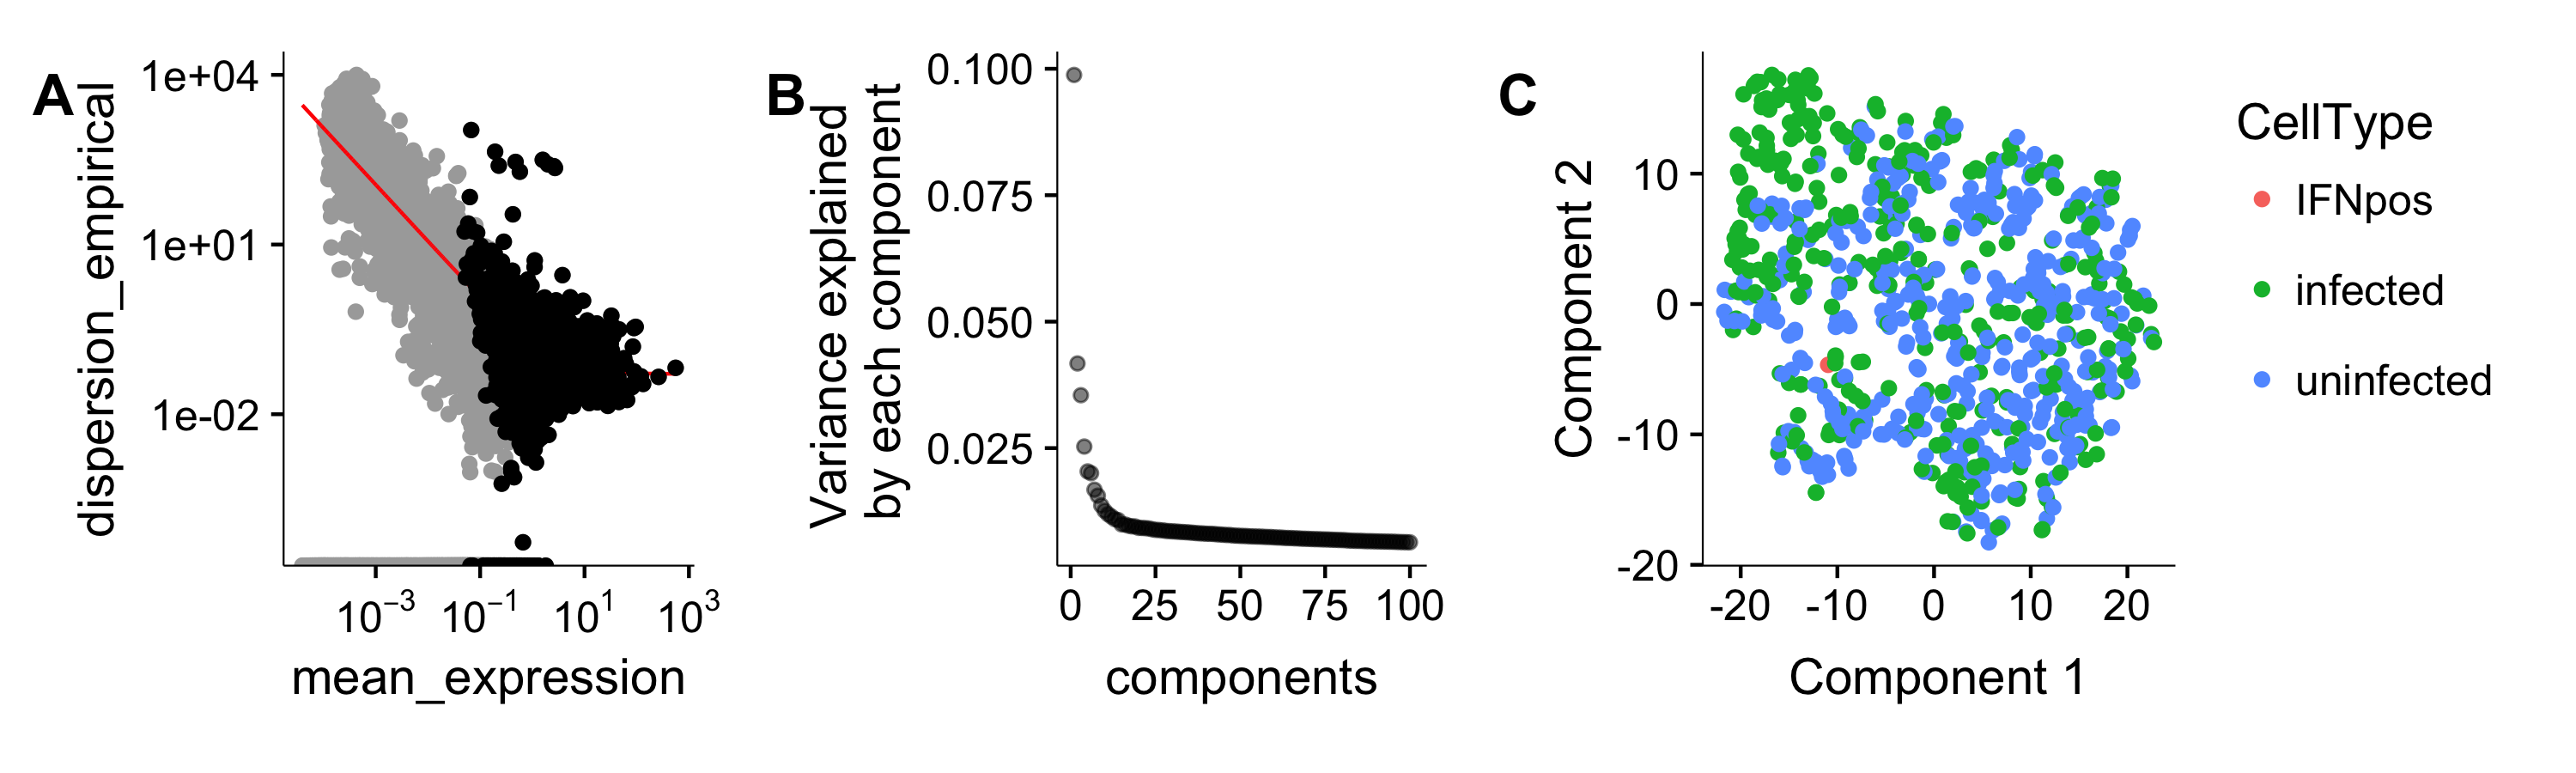

In [22]:
disp_table <- dispersionTable(cells)
unsup_clustering_genes <- subset(disp_table, mean_expression > 0.05)
cells <- setOrderingFilter(cells, unsup_clustering_genes$gene_id)

p.disp.vs.expr <- plot_ordering_genes(cells) + scale_x_log10(labels=fancy_scientific)

p.pc.variance <- plot_pc_variance_explained(cells, return_all=FALSE)

cells <- reduceDimension(cells, max_components=2, num_dim=6, 
  reduction_method='tSNE', verbose=TRUE, 
  residualModelFormulaStr="~Sample + num_genes_expressed")
cells <- clusterCells(cells, num_clusters=2)
p.tsne <- plot_cell_clusters(cells, color="CellType") + 
  guides(color=guide_legend(nrow=4)) + theme(legend.position="right")

p.unsup.tsne <- plot_grid(p.disp.vs.expr, p.pc.variance, p.tsne, nrow=1, 
  labels="AUTO", label_size=16, align='h', scale=0.93, rel_widths=c(1, 1, 1.5))

saveShowPlot(p.unsup.tsne, width=10, height=3)

## Supervised clustering of the genes
Now we'll re-do the tSNE clustering but use supervised clustering as in the Monocle vignette.

In [ ]:
marker_diff <- markerDiffTable(cells, cth, 
  residualModelFormulaStr="~Sample + num_genes_expressed", cores=detectCores())

In [ ]:
marker_diff %>% filter(gene_short_name %in% flugenes)